# Algorithmic Trading

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
tickers = ['AAPL', 'MSFT','RS','UL','HINDUNILVR.NS']
names=['Apple','Microsoft','Reliance','Unilever','H.U.L.']

file=["AAPL dataset.csv","MSFT dataset.csv","RELIANCE.BO dataset.csv","UL dataset.csv",'HINDUNILVR.NS dataset.csv']
company=[]

for i in range(len(tickers)):
    company.append(pd.read_csv(file[i]))
    company[i]["Date"] = pd.to_datetime(company[i]["Date"])

In [3]:
company[0].head() #Apple
company[0].dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

## Moving Averages 10, 20 & 50
Calculating and adding 3 moving averages columns

In [4]:
for i in range(len(company)):
    company[i]['MovingAverage5'] = company[i].iloc[:,4].rolling(window=5).mean().round(4)
    company[i]['MovingAverage10'] = company[i].iloc[:,4].rolling(window=10).mean().round(4)
    company[i]['MovingAverage20'] = company[i].iloc[:,4].rolling(window=20).mean().round(4)
    company[i]['MovingAverage50'] = company[i].iloc[:,4].rolling(window=50).mean().round(4)

## RSI Calculation

### RSI 1
Gain & Loss( = Difference in Closing Values (AL is taken in positive)

Average Gain(AL) & Average Loss(AL) = Average Gain/Average loss for a period of 14 days

$$RSI_1=100-\bigg(\frac{100}{1+\frac{AG}{AL}}\bigg)$$

In [5]:
def rsi1(data):
    Close=data['Close']
    Open=data['Open']
    AG=np.zeros_like(Open)
    AL=np.zeros_like(Open)
    RSI1=np.zeros_like(Open)
    
    for i in range(0,len(Open)-14):
        for j in range(i,i+14):
            gain=Close[j+1]-Close[j]
            if(gain>=0):
                AG[i+14]+=gain
            else:
                AL[i+14]+=-gain
        
        if(AL[i+14]==0):
            RSI1[i+14]=100
        else:
            RSI1[i+14]=100-(100/(1+((AG[i+14]/AL[i+14]))))
    
    n=0
    for i in RSI1:
        if(i==0):
            RSI1[n]=float('NaN')
        n+=1
    
    return([RSI1,AG,AL])

### RSI 2
For smoothening the RSI1 values

Gain & Loss( = Difference in Closing Values (AL is taken in positive)

Average Gain(AL) & Average Loss(AL) = Average Gain/Average loss for a period of 14 days = (Gain *or* Loss)/14 

Previous Average Gain(PAG) & Previous Average Loss(PAL) = Average Gain/Average Loss in the previous 14 days

$$RSI_1=100-\bigg(\frac{100}{1+\frac{13PAG+AG}{13PAL+AL}}\bigg)$$

In [6]:
def rsi2(data):
    Close=data['Close']
    Open=data['Open']
    AG2=np.zeros_like(Open)
    AL2=np.zeros_like(Open)
    RSI2=np.zeros_like(Open)
    
    PAG=rsi1(data)[1]
    PAL=rsi1(data)[2]
    
    for i in range(14,len(Open)-14):
        for j in range(i,i+14):
            gain=Close[j+1]-Close[j]
            if(gain>=0):
                AG2[i+14]+=gain
            else:
                AL2[i+14]+=-gain
         
        AG2[i+14]/=14
        AL2[i+14]/=14
        PAG[i]/=14
        PAL[i]/=14
        
        if((PAL[i]*13)+AL2[i+14]==0):
            RSI2[i]=100
        else:
            RSI2[i]=100-(100/(1+(((PAG[i]*13)+AG2[i+14])/((PAL[i]*13)+AL2[i+14]))))
    
    n=0
    for i in RSI2:
        if(i==0):
            RSI2[n]=float('NaN')
        n+=1
    return(RSI2)

## Plotting function
To plot the Stock Prices with time

To plot the RSI values just below it

In [7]:
def plotting(data,name,num): 
    import matplotlib.dates as mdates
    plt.figure(num,figsize=(15,10))
    plt.grid()
    plt.plot(data['Date'],data['Close'],linewidth=3)
    plt.plot(data['Date'],data['MovingAverage5'])
    plt.plot(data['Date'],data['MovingAverage10'])
    plt.plot(data['Date'],data['MovingAverage20'])
    plt.plot(data['Date'],data['MovingAverage50'])
    plt.legend(['Stock Prices','MovAvg5','MovAvg10','MovAvg20','MovAvg50'])
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title('%s Stocks'%name)
    #plt.xticks(rotation='horizontal')    
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    plt.gcf().autofmt_xdate()

    plt.figure(num+1,figsize=(15,6))
    plt.grid()
    plt.plot(data['Date'],rsi1(data)[0],'y--')
    plt.plot(data['Date'],rsi2(data),'b',linewidth=3)
    plt.axhline(y=70,color='red',linestyle=':',linewidth=2)
    plt.axhline(y=50,linestyle=':',linewidth=0.5)
    plt.axhline(y=30,color='green',linestyle=':',linewidth=2)
    plt.legend(['RSI1','RSI2','Overbought','Oversold'])
    plt.xlabel('Date')
    plt.ylabel('RSI value')
    plt.ylim(0,100)
    plt.title('RSI Plots')
    #plt.xticks(rotation='horizontal')
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    plt.gcf().autofmt_xdate()

In [8]:
def printValue(data,days,roundoff,name):
    total=len(data['Date'])
    if days>14:
        print('RSI1 Value for',name,'on %s:'%data['Date'][total-days],rsi1(data)[0][-days].round(roundoff))
        print('RSI2 Value on %s:'%data['Date'][total-days],rsi2(data)[-days].round(roundoff))
    else:
        print('RSI Value for',name,'on %s:'%data['Date'][total-days],rsi1(data)[0][-days].round(roundoff))

## Decision Maker Algorithm

In [9]:
def decision(rsi,ma5,ma10,ma20,ma50,c):
    string='DECISION = '
    
    if(rsi<30 and ma5<ma50 and ma10<ma50 and ma20<ma50):
        string+='STRONG BUY!'
    elif((rsi<30 and ma10<ma50) or (ma10<ma50 and ma50>ma20)):
        string+='Buy'
    elif(rsi>70 and ma20>ma50 and 3*np.abs(ma10-ma5)<np.abs(ma50-ma5) and np.abs(ma50-ma20)>np.abs(ma20-ma5)):
        string+='STRONG SELL!'
    elif((rsi>70 and ma10>ma50) or (3*np.abs(ma10-ma5)<np.abs(ma50-ma5) and ma20>ma50)):
        string+='Sell'
    else:
        string+='Neutral'
    if(c==0):
        print(string)
    elif(c==1):
        return(string)

## Stocks and RSI Graphs

Input days before last trading day = 10
RSI Value for Apple on 2021-07-15 00:00:00: 86.07
DECISION = Sell


RSI Value for Microsoft on 2021-07-15 00:00:00: 75.7
DECISION = Sell


RSI Value for Reliance on 2021-07-14 00:00:00: 37.72
DECISION = Buy


RSI Value for Unilever on 2021-07-15 00:00:00: 54.71
DECISION = Buy


RSI Value for H.U.L. on 2021-07-14 00:00:00: 34.61
DECISION = Neutral




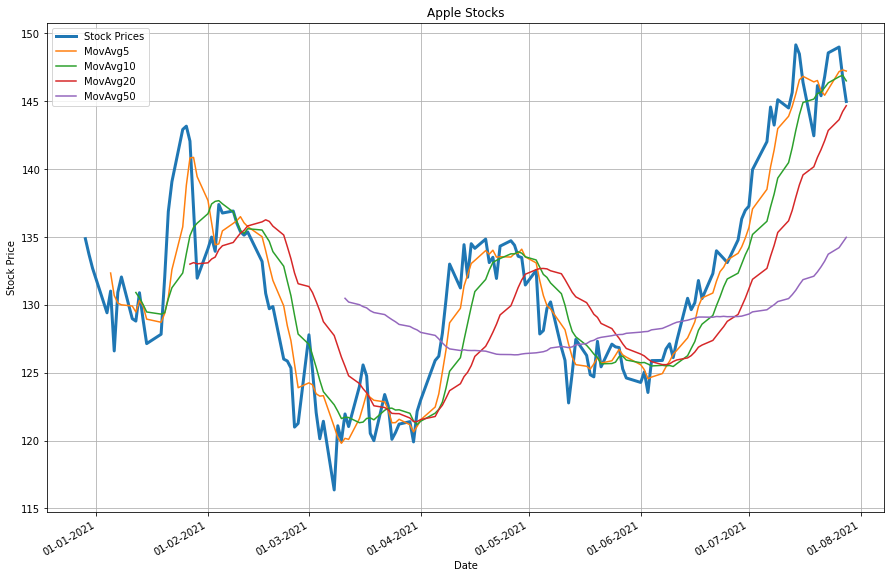

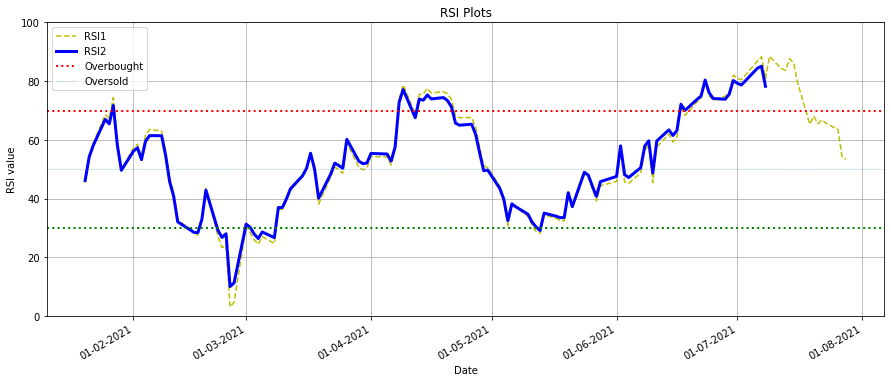

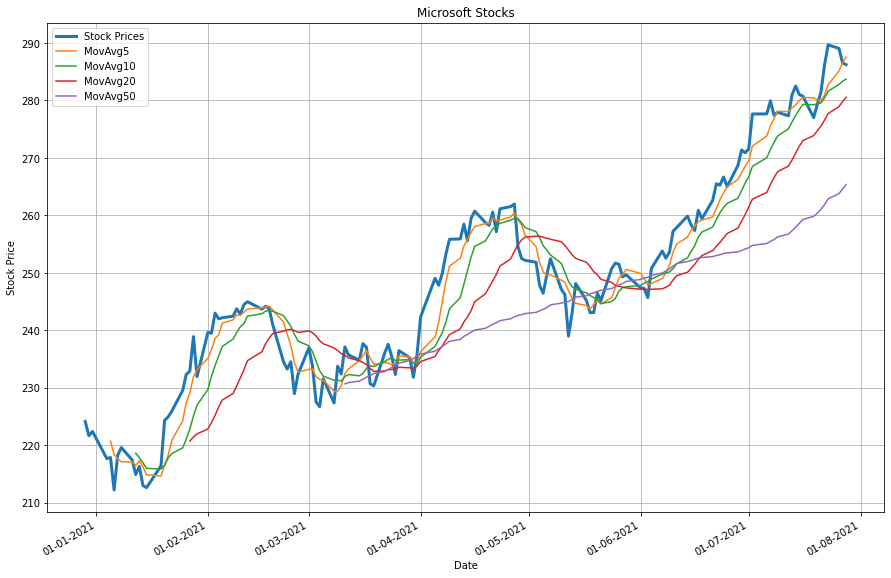

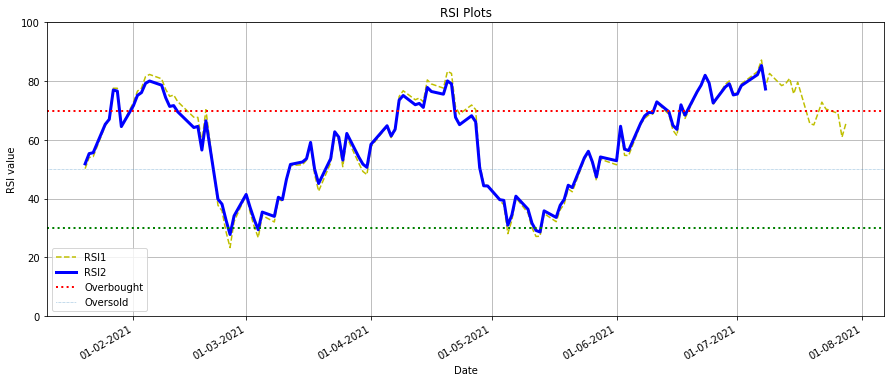

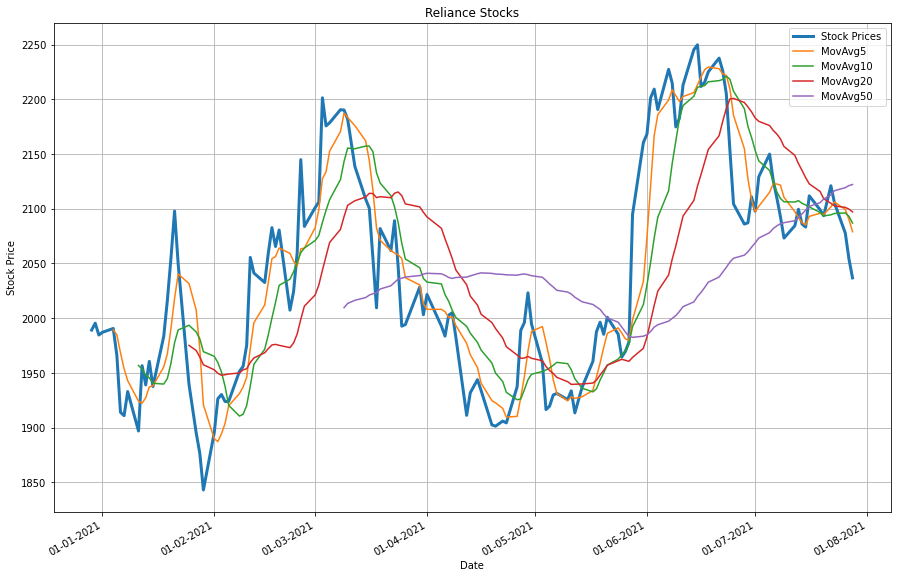

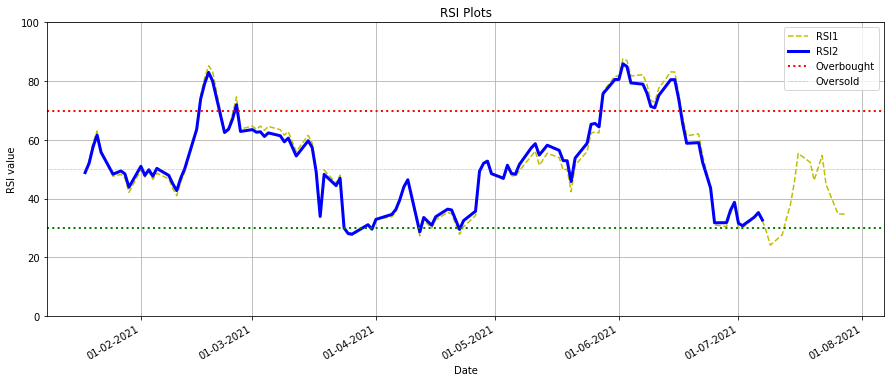

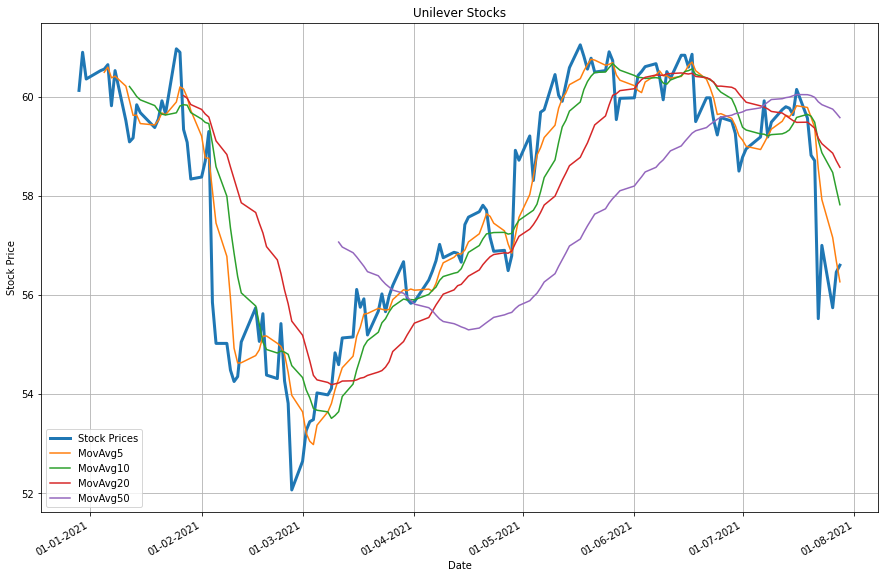

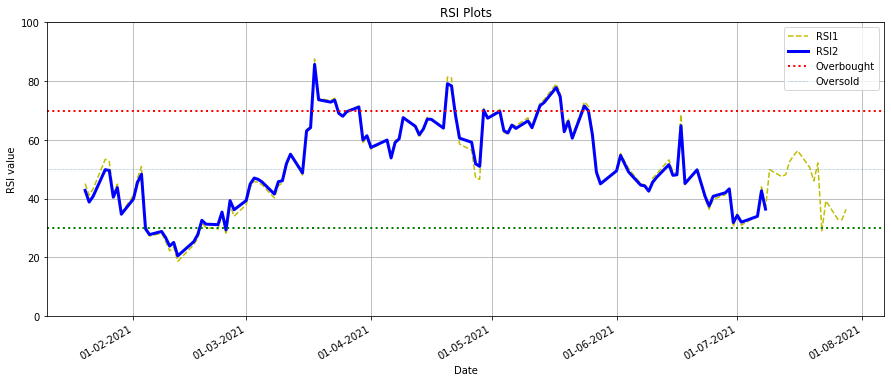

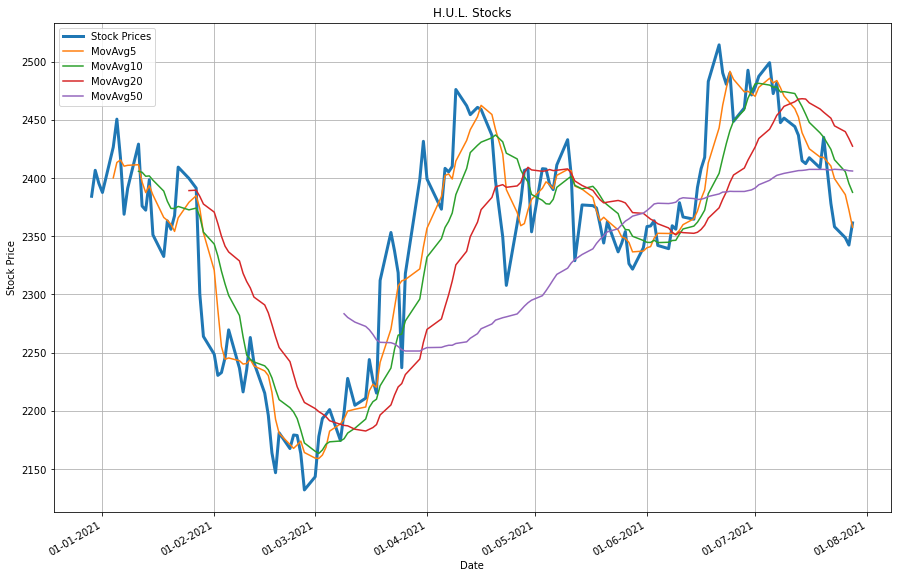

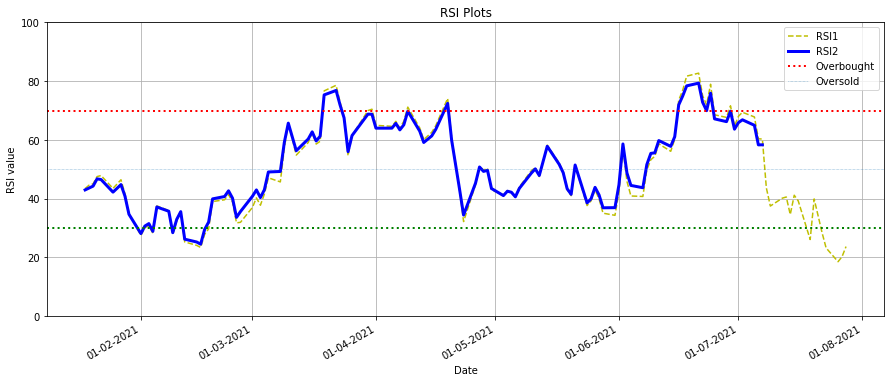

In [10]:
days=input("Input days before last trading day = ")
for i in range(len(company)):
    printValue(company[i],int(days),2,names[i])
    plotting(company[i],names[i],(2*i)+1)
    length = len(company[i])-1
    if(int(days)<=14):
        decision(rsi2(company[i])[length],company[i]['MovingAverage5'][length],company[i]['MovingAverage10'][length],company[i]['MovingAverage20'][length],company[i]['MovingAverage50'][length],0)
    else:
        decision(rsi1(company[i])[0][length],company[i]['MovingAverage5'][length],company[i]['MovingAverage10'][length],company[i]['MovingAverage20'][length],company[i]['MovingAverage50'][length],0)
    print('\n')

## Backtesting

In [11]:
money=0
k=0
num=1
for i1 in company:
    for i in np.arange(50,len(i1['Close']),14):
        if(len(i1['Close'])-i>14):
            dec=decision(rsi2(i1)[i],i1['MovingAverage5'][i],i1['MovingAverage10'][i],i1['MovingAverage20'][i],i1['MovingAverage50'][i],1)
            if((dec=='DECISION = Buy' or dec=='DECISION = STRONG BUY!') and k%2==0):
                money-=i1['Close'][i]
                k+=1
            elif(dec=='DECISION = Sell' or dec=='DECISION = STRONG SELL!' and k%2==1):
                money+=i1['Close'][i]
                k+=1
        else:
            dec=decision(rsi1(i1)[0][i],i1['MovingAverage5'][i],i1['MovingAverage10'][i],i1['MovingAverage20'][i],i1['MovingAverage50'][i],1)
            if(dec=='DECISION = Buy' or dec=='DECISION = STRONG BUY!'):
                money-=i1['Close'][i]
            elif(dec=='DECISION = Sell' or dec=='DECISION = STRONG SELL!'):
                money+=i1['Close'][i]
    print('Money made in total in company',str(num),' =',money)
    num+=1

Money made in total in company 1  = 165.46999999999997
Money made in total in company 2  = 479.48002499999996
Money made in total in company 3  = 7005.130172
Money made in total in company 4  = 7182.810173
Money made in total in company 5  = 14448.310173000002


POSITIVE PROFITS!